In [19]:
import os
import glob

from dataclasses import dataclass
from typing import Dict, List

import cv2 as cv
import numpy as np
import open3d as o3d

from matplotlib import pyplot as plt

# Stereo Vision

### Dataset

- 2021 Mobile stereo datasets with ground truth: [source](https://vision.middlebury.edu/stereo/data/scenes2021/) | [paper](https://link.springer.com/chapter/10.1007/978-3-319-11752-2_3)


In [171]:
dataset_url = "https://vision.middlebury.edu/stereo/data/scenes2021/zip/all.zip"
dataset_path = "dataset/"

In [172]:
# uncomment to download & unzip dataset

# Download dataset
# !wget -nc -P $dataset_path $dataset_url

# Unzip dataset
# !unzip -n $dataset_path -d dataset

In [234]:
@dataclass
class StereoData:
    img_0: np.ndarray
    img_1: np.ndarray
    disp_gt_0: np.ndarray
    disp_gt_1: np.ndarray
    cam_0: np.ndarray
    cam_1: np.ndarray
    doffs: float
    baseline: float
    width: int
    height: int
    ndisp: int
    vmin: int
    vmax: int
    f: float
    disp_0: np.ndarray
    disp_1: np.ndarray
    depth_0: np.ndarray
    depth_1: np.ndarray

# Load images
dataset_path = "dataset/data"
select_dataset = ["chess", "curule", "skiboots"]
loaded_dataset : Dict[str, List[StereoData]] = {}
    

for dataset in select_dataset:
    dataset_folders = glob.glob(os.path.join(dataset_path, f"{dataset}{'*'}"))

    loaded_sub_dataset = []

    for folder in dataset_folders:
        # Load images
        img_0 = cv.imread(os.path.join(folder, "im0.png"))
        img_1 = cv.imread(os.path.join(folder, "im1.png"))

        # Load disparity maps (ground truth)
        disp_0 = cv.imread(os.path.join(folder, "disp0.pfm"))
        disp_1 = cv.imread(os.path.join(folder, "disp1.pfm"))

        # Load camera parameters
        with open(os.path.join(folder, "calib.txt")) as f:
            lines = f.readlines()

            K_0 = np.array([float(x) for x in lines[0].split('=')[-1].strip('[]\n').replace(';', ' ').split()]).reshape(3, 3)
            K_1 = np.array([float(x) for x in lines[1].split('=')[-1].strip('[]\n').replace(';', ' ').split()]).reshape(3, 3)

            doffs = float(lines[2].split('=')[-1])
            baseline = float(lines[3].split('=')[-1])
            width = int(lines[4].split('=')[-1])
            height = int(lines[5].split('=')[-1])
            ndisp = int(lines[6].split('=')[-1])
            vmin = int(lines[7].split('=')[-1])
            vmax = int(lines[8].split('=')[-1])

            loaded_sub_dataset.append(StereoData(img_0, img_1, disp_0, disp_1, K_0, K_1, doffs, baseline, width, height, ndisp, vmin, vmax, K_0[0, 0], None, None, None, None))


    loaded_dataset[dataset] = loaded_sub_dataset

### Camera Calibration & Stereo Rectification

The dataset provide calibrated and rectified images. These tasks will need to be implemented for the realtime version. Camera calibration info are accessible through android API.

### Stereo Matching

OpenCV implements 3 diffferent stereo matching algorithms:

- StereoBM: [api](https://docs.opencv.org/4.x/d7/d8e/classcv_1_1stereo_1_1StereoBinaryBM.html)
- StereoSGBM: [api](https://docs.opencv.org/4.x/d1/d9f/classcv_1_1stereo_1_1StereoBinarySGBM.html) | [paper](https://ieeexplore.ieee.org/abstract/document/4359315)
- Quasi dense Stereo (ZNCC): [api](https://docs.opencv.org/4.x/dc/df4/classcv_1_1stereo_1_1QuasiDenseStereo.html) | [paper](https://link.springer.com/chapter/10.1007/978-3-642-15705-9_34)

And some CUDA implementations:
- StereoBeliefPropagation: [api](https://docs.opencv.org/4.x/de/d7a/classcv_1_1cuda_1_1StereoBeliefPropagation.html) | [paper](https://ieeexplore.ieee.org/document/1315041)
- StereoConstantSpaceBP: [api](https://docs.opencv.org/4.x/d7/d09/classcv_1_1cuda_1_1StereoConstantSpaceBP.html) | [paper](https://ieeexplore.ieee.org/document/5539797)


In [226]:
def get_disparity(left_img: cv.Mat, right_img: cv.Mat, f: float, baseline: float, doffs: float, ndisp: int, vmin: float, vmax: float) -> tuple[cv.Mat, cv.Mat]:
    left_gray = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
    right_gray = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)

    # Compute disparity map
    stereo = cv.StereoSGBM_create(
        minDisparity=vmin, 
        numDisparities=256, 
        blockSize=11, 
        P1=8 * 3 * 3 ** 2, 
        P2=32 * 3 * 3 ** 2, 
        disp12MaxDiff=1, 
        uniquenessRatio=10, 
        speckleWindowSize=100, 
        speckleRange=64,
        mode=cv.StereoSGBM_MODE_HH)

    disp = stereo.compute(left_gray, right_gray)
    disp_norm = cv.normalize(disp.astype(np.float32), 0, 255, cv.NORM_MINMAX)

    # Convert disparity to depth
    depth = f * baseline / (disp.astype(np.float32) + max(1e-6, doffs))
    return disp, depth
    

def disparity_wrapper(stereo_data: StereoData) -> tuple[cv.Mat, cv.Mat]:
    return get_disparity(stereo_data.img_0, stereo_data.img_1, stereo_data.f, stereo_data.baseline, stereo_data.doffs, stereo_data.ndisp, stereo_data.vmin, stereo_data.vmax)

def plot_imgs(imgs: List[np.ndarray], title: str,  figsize: tuple[int, int] = (15, 10)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i + 1)
        plt.imshow(cv.normalize(img.astype(np.float32), 0, 255, cv.NORM_MINMAX))
        plt.title(f'{title} {i}')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [227]:
chess_results = [disparity_wrapper(x) for x in loaded_dataset["chess"]]
curule_results = [disparity_wrapper(x) for x in loaded_dataset["curule"]]
skiboots_results = [disparity_wrapper(x) for x in loaded_dataset["skiboots"]]

In [235]:
chess_disp = [x[0] for x in chess_results]
chess_depth = [x[1] for x in chess_results]
for i, ld in enumerate(loaded_dataset["chess"]):
    ld.disp_0 = chess_disp[i]
    ld.depth_0 = chess_depth[i]

curule_disp = [x[0] for x in curule_results]
curule_depth = [x[1] for x in curule_results]
for i, ld in enumerate(loaded_dataset["curule"]):
    ld.disp_0 = curule_disp[i]
    ld.depth_0 = curule_depth[i]

skiboots_disp = [x[0] for x in skiboots_results]
skiboots_depth = [x[1] for x in skiboots_results]
for i, ld in enumerate(loaded_dataset["skiboots"]):
    ld.disp_0 = skiboots_disp[i]
    ld.depth_0 = skiboots_depth[i]

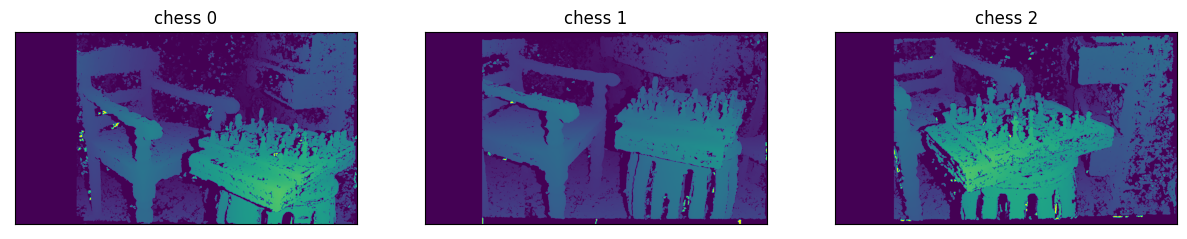

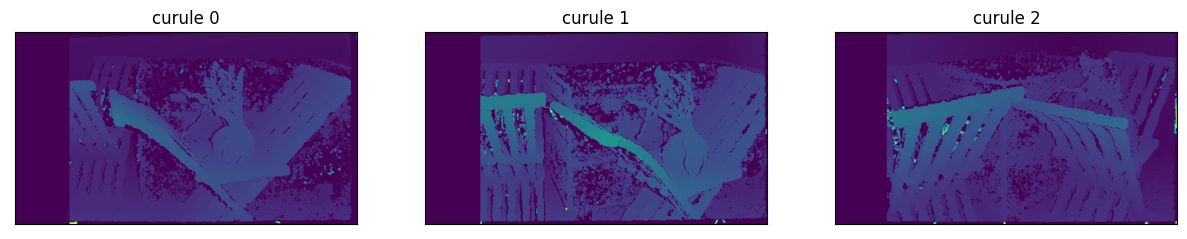

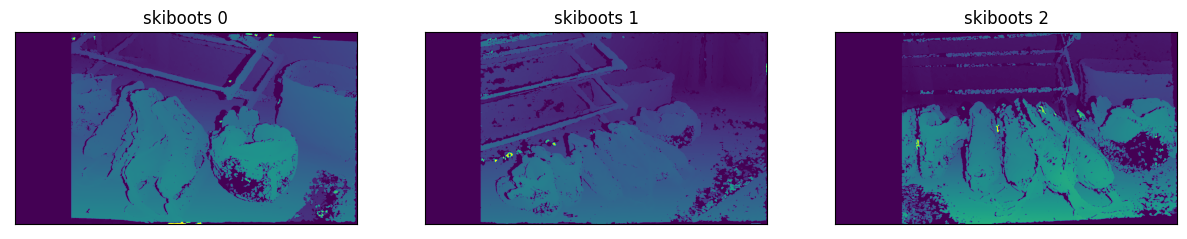

In [236]:
plot_imgs(chess_disp, 'chess')
plot_imgs(curule_disp, 'curule')
plot_imgs(skiboots_disp, 'skiboots')

### Point Cloud

In [237]:
# ply_header = '''ply
# format ascii 1.0
# element vertex %(vert_num)d
# property float x
# property float y
# property float z
# property uchar red
# property uchar green
# property uchar blue
# end_header
# '''

def get_pointclout(left_img: cv.Mat, disp: cv.Mat, depth: np.ndarray, f: float, vmin: float, vmax: float) -> np.ndarray:
    # Convert depth to point cloud
    h, w = left_img.shape[:2]
#     x, y = np.meshgrid(np.arange(w), np.arange(h))
#     x, y, z = x.flatten(), y.flatten(), depth.flatten()
#     points = np.vstack((x, y, z)).T

    Q = np.float32([[1, 0, 0, -0.5*w],
                    [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
    points = cv.reprojectImageTo3D(disp, Q).reshape(-1, 3)
    colors = cv.cvtColor(left_img, cv.COLOR_BGR2RGB).reshape(-1, 3)

    # filter noise
    # points_mask = np.logical_and(disp > vmin, disp < vmax)
    # points = points[points_mask].reshape(-1, 3)
    # colors = colors[points_mask].reshape(-1, 3)

    # save point cloud
    # verts = np.hstack([points, colors])
    # with open('res_cv.ply', 'wb') as f:
    #     f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
    #     np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

    # alternative method with open3d
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors.astype(np.float32) / 255.0)
    # o3d.io.write_point_cloud("res_o3d.ply", pcd)

    # rendering issue on WSL2
    # o3d.visualization.draw_geometries([pcd])
    return pcd

def pointcloud_wrapper(stereo_data: StereoData) -> np.ndarray:
    return get_pointclout(stereo_data.img_0, stereo_data.disp_0, stereo_data.depth_0, stereo_data.f, stereo_data.vmin, stereo_data.vmax)

In [239]:
chess_results_2 = [pointcloud_wrapper(x) for x in loaded_dataset["chess"]]
curule_results_2 = [pointcloud_wrapper(x) for x in loaded_dataset["curule"]]
skiboots_results_2 = [pointcloud_wrapper(x) for x in loaded_dataset["skiboots"]]

### Point Cloud Registration

In [263]:
def preprocess_point_cloud(pcd, voxel_size):
    pcd_down = pcd.voxel_down_sample(voxel_size)
    radius_normal = voxel_size * 2
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result


:: Downsample with a voxel size 0.010.
:: Estimate normal with search radius 0.020.
:: Compute FPFH feature with search radius 0.050.
:: Downsample with a voxel size 0.010.
:: Estimate normal with search radius 0.020.
:: Compute FPFH feature with search radius 0.050.
(2073600, 3) (20684, 3)
:: Apply fast global registration with distance threshold 0.005
Initial alignment
RegistrationResult with fitness=1.092178e-01, inlier_rmse=1.245945e-02, and correspondence_set size of 226474
Access transformation to get result.


In [ ]:
voxel_size = 0.01
threshold = 0.02
source = chess_results_2[0]
target = chess_results_2[1]
source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)

print(np.asarray(source.points).shape, np.asarray(source_down.points).shape)

result_fast = execute_fast_global_registration(source_down, target_down,
                                               source_fpfh, target_fpfh,
                                               voxel_size)

trans_init = result_fast.transformation
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

In [265]:
# "Apply point-to-point ICP"
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
trans_icp = reg_p2p.transformation
source_transformed = source.transform(trans_icp)

Apply point-to-point ICP
RegistrationResult with fitness=9.003038e-02, inlier_rmse=1.216035e-02, and correspondence_set size of 186687
Access transformation to get result.


True

In [266]:
pcd_combined = o3d.geometry.PointCloud()
pcd_combined += target
pcd_combined += source
o3d.io.write_point_cloud("res_combined.ply", pcd_combined)

True

Result, shown from image due to rendering issues, these will be fixed in the final version
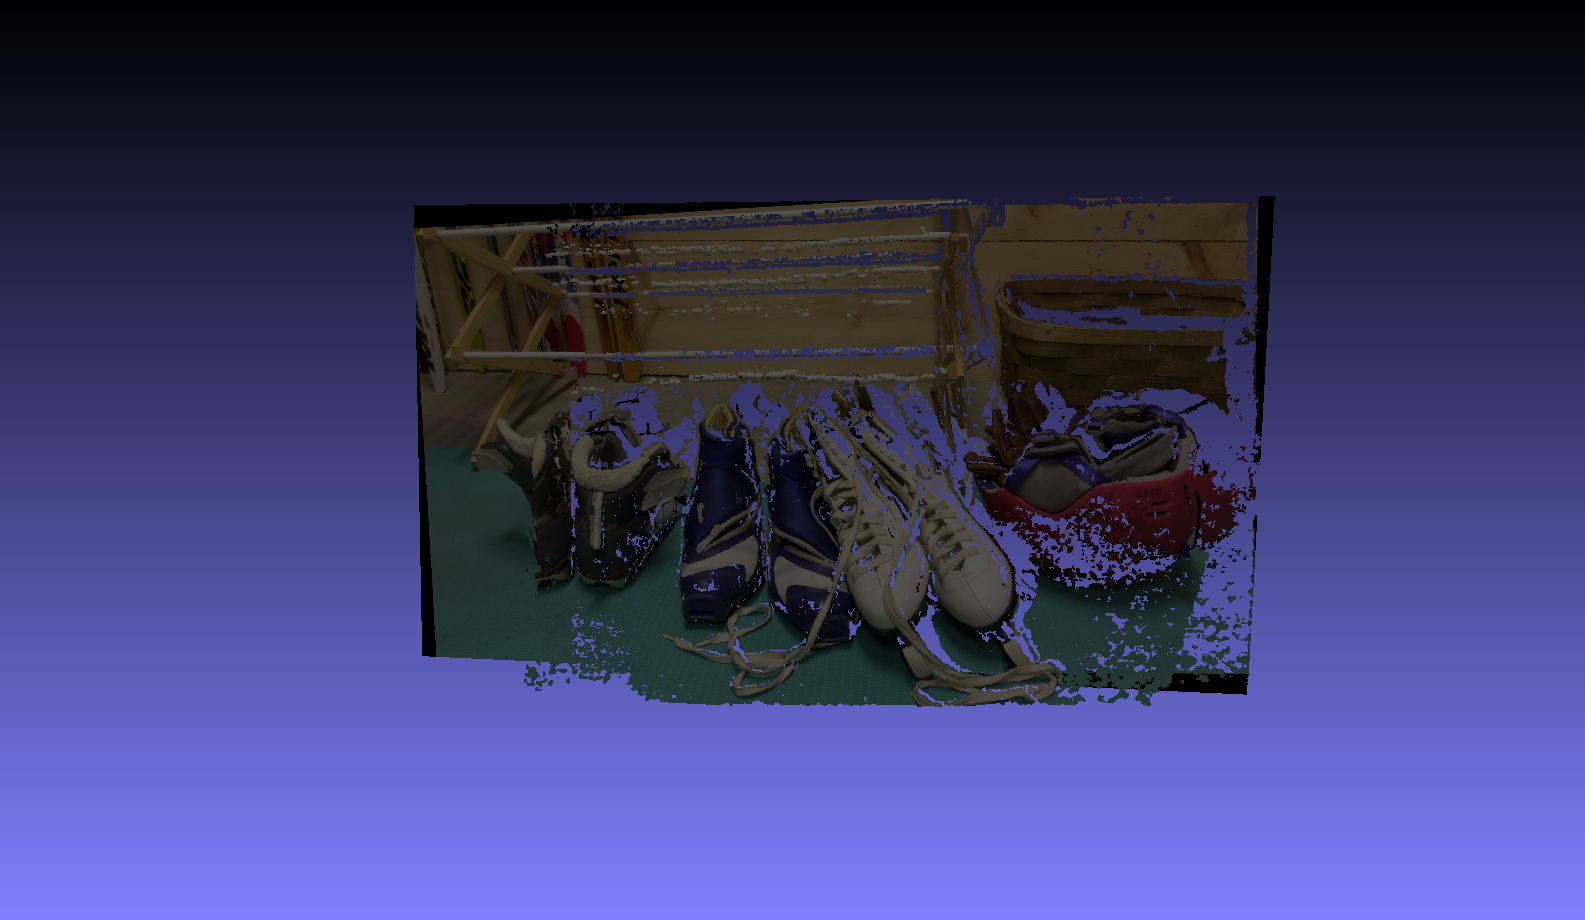

### Challenges
- Point cloud registration needs more work for better alignment
- The dataset uses identical cameras for both left and right images, results may not be as good with phone cameras with different lenses. worst case scenario I can adapt this code to do Structure from Motion using a single camera.

# Alternative approaches

### Structure from Motion
    - https://github.com/openMVG/openMVG
    - https://github.com/SpectacularAI/TheiaSfM
### Visial SLAM
    -
### Visial-Inertial Odometry
    - https://arxiv.org/abs/2106.11857